<a href="https://colab.research.google.com/github/kush1314/Financial-Analysis-and-News-Summarization-System/blob/main/Stocksim_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install pandas_datareader --upgrade
!pip install arch
!pip install newsapi-python
!pip install scrapy
!pip install newsapi-python transformers
!pip install sumy
!pip install newspaper3k
!pip install openai newspaper3k
!pip install transformers
!pip install --upgrade newsapi-python
!pip install requests beautifulsoup4 transformers
!pip install newsapi-python transformers requests beautifulsoup4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.3 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21691 sha256=fe072b127bc61ef13b018d84eaed2

In [ ]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import scrapy
import sumy
import openai
from newspaper import Article
import requests
from bs4 import BeautifulSoup
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from huggingface_hub import login
from newsapi import NewsApiClient
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import requests
from bs4 import BeautifulSoup


In [15]:
#DISCLAIMER: Due to a data-overload issue we are still working on, the output box will first say there is an error with the API key,
# however, if you wait another 15 seconds the code will return to working normally
from newsapi import NewsApiClient
import requests
from bs4 import BeautifulSoup
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

api_key = "official_apikey"  # Secret key
api = NewsApiClient(api_key=api_key)  # Set api key

search = input('Input the search topic\n')

def get_article_text(url): #Stores the text
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser') #Beautiful soup API in order to get text strips
        paragraphs = soup.find_all('p')
        text = ' '.join(paragraph.get_text(strip=True) for paragraph in paragraphs)
        return text.strip()
    except requests.RequestException as e:
        print(f"Error fetching article: {e}") #For errors
        return ""

def summarize_article(article, summarizer, summary_length):  #Gets the url in order to get the article text
    selected_url = article['url']
    text = get_article_text(selected_url)

    if len(text) == 0:
        print("The article content couldn't be fetched. Please try another article.") #For errors
        return None

    word_count = len(text.split())
    if word_count < 200:
        print(f"The article is too short to summarize (word count: {word_count}).") #For errors
        return None

    try:
        if summary_length < 50: #length for sumamry
            summary_length = 50
        elif summary_length > 1000:
            summary_length = 1000

        summary = summarizer(text, max_length=summary_length, min_length=summary_length, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error generating summary: {e}") #For errors
        return None

def print_summary_in_chunks(summary, chunk_size=2000):  #Printing the summary
    for i in range(0, len(summary), chunk_size):
        print(summary[i:i + chunk_size])
        if i + chunk_size < len(summary):
            input("Press Enter to see more...")

def filter_articles(articles):
    """Filter out articles with URLs containing 'consent.yahoo.com' or those that are too short."""
    filtered_articles = []
    for article in articles:
        if 'consent.yahoo.com' in article['url']: #Consent.yahoo articles won't work so filter them out
            continue

        # Check if the article is too short
        article_text = get_article_text(article['url'])
        if len(article_text.split()) < 200: #check split length
            continue

        filtered_articles.append(article)
    return filtered_articles #Return the articles that are filtered

def get_valid_articles(articles, required_count=50):
    valid_articles = []
    index = 0

    while len(valid_articles) < required_count and index < len(articles):
        article = articles[index]
        summary = summarize_article(article, summarizer, 100) #Instantiate

        if summary is not None:
            valid_articles.append(article) #Append into the array
        index += 1

    if len(valid_articles) < required_count:
        response = api.get_everything(q=search, language='en', sort_by='relevancy', page_size=100). #get the required articles
        additional_articles = filter_articles(response.get('articles', []))
        valid_articles += get_valid_articles(additional_articles, required_count - len(valid_articles))

    return valid_articles

try:
    response = api.get_everything(q=search, language='en', sort_by='relevancy', page_size=100) #Sets response
    if response['status'] != 'ok':
        raise Exception(f"API returned status: {response['status']}")
    articles = response.get('articles', [])
    if not articles:
        print("No articles found.")
except Exception as e:
    print(f"Error retrieving articles: {e}") #For errors

if not articles:
    print("No articles found for the search topic.")# For errors
else:
    token = "token_1" #Token key for Hugging Face's BART
    tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn", use_auth_token=token)
    model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn", use_auth_token=token)
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer) #Summarization tool

    articles = filter_articles(articles)

    summaries = [] #array for summaries

    for idx, article in enumerate(articles[:50]): #for loop over the 50 articles to retreive the relevent information
        print(f'Article {idx}\nTitle: {article["title"]}\nAuthor: {article["author"]}\nDescription: {article["description"]}\nURL: {article["url"]}\n\n')

    while True:
        article_index = int(input("Enter the number of the article you'd like a summary of: ")) #Input for articles
        if 0 <= article_index < len(articles):
            try:
                summary_length = int(input("How many words do you want the summary to be? ")) #Input for words
            except ValueError:
                print("Invalid input. Please enter a number.") #For errors
                continue

            summary = summarize_article(articles[article_index], summarizer, summary_length) #Instantation for method input for summary

            if summary:
                print(f"\nSummary of Article {article_index}:\n") #If summary is true add to the list and print
                print_summary_in_chunks(summary)
                summaries.append(summary)
        else:
            print("Invalid article number. Please enter a number from the list.") #For erros

        another = input("Do you want a summary of another article? (yes/no): ").strip().lower() #Input for more summaries
        if another != 'yes':
            print("Sounds good, hope you found what you needed. Here are your summary results:")
            for i, summary in enumerate(summaries):
                print(f"\nSummary {i + 1}:\n{summary}\n")
            break

Input the search topic
tesla
Error retrieving articles: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
Article 0
Title: The 2025 Ford Maverick Shows That Hybrid Pickup Trucks Are Going Mainstream
Author: Bob Sorokanich
Description: Just as Tesla ditches its $60,000 Cybertruck, Ford finally allows buyers to pair its efficient hybrid powertrain with all-wheel drive and a towing package. Hallelujah.
URL: https://www.wired.com/story/the-2025-ford-maverick-shows-that-hybrid-pickup-trucks-are-going-mainstream/


Article 1
Title: Tesla Issues Physical Recall After Vehicles Literally Come Unglued
Author: Matt Novak
Description: While most Tesla recalls have involved over-the-air updates, this one requires a physical inspection.
URL: https://gizmodo.com/tesla-issues-physical-recall-after-vehicles-literally-come-unglued-2000489406


Article 2
Title: Tesla Is Hiring Humans to W

KeyboardInterrupt: 

Enter the stock symbol you want to analyze: APPL
Enter the period (e.g., 1d, 5d, 1mo, 3mo, 1y, etc.): 5d


ERROR:yfinance:APPL: Period '5d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


Error: name 'mdates' is not defined
Please check the stock symbol and period format.


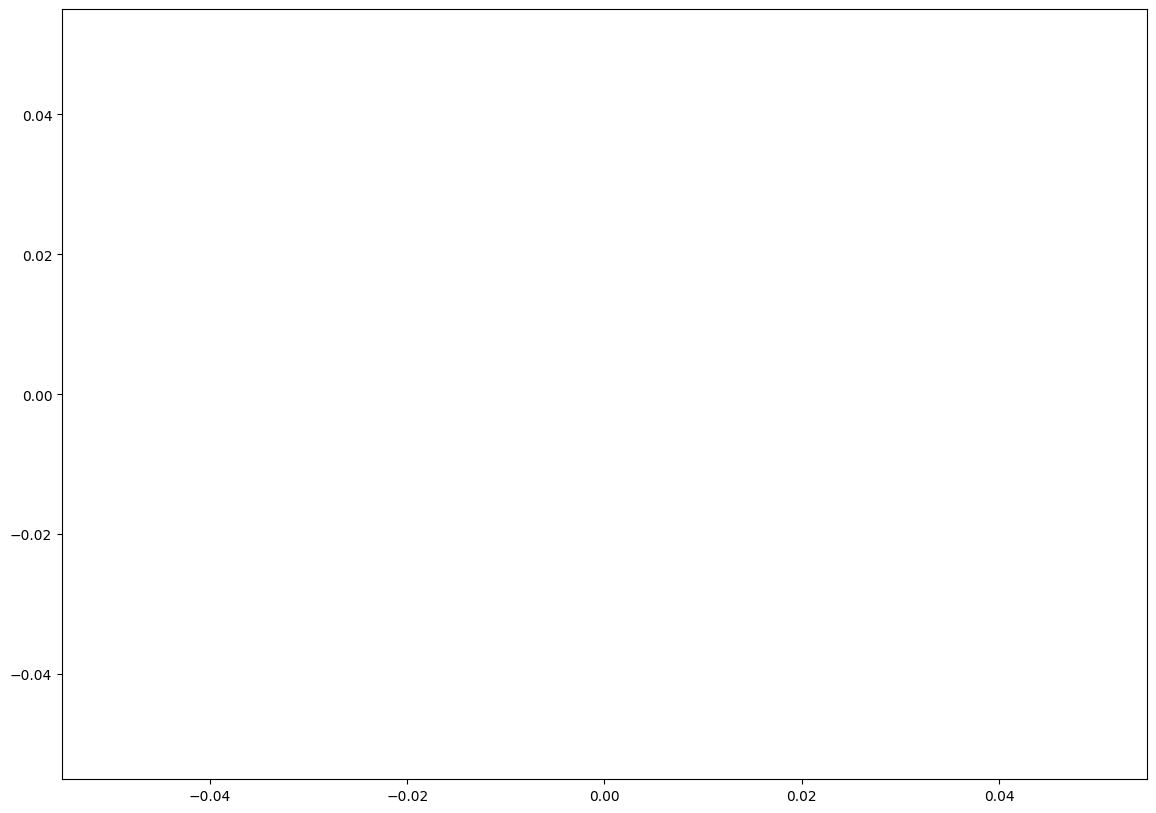

In [ ]:
def get_stock_data(symbol, period):
    stock = yf.Ticker(symbol)
    data = stock.history(period=period) #had to make this a multiple day period to plot data
    return data

def plot_stock_chart(data):
    plt.figure(figsize=(14, 10))
    plt.plot(data.index, data['Close'], label='Close Price', color='red')
      #i think you need this to plot the line:)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Price Chart')
    plt.legend()
    plt.grid(True)
    plt.show()



def display_stock_info(data):
    latest_data = data.iloc[-1]  # Get the latest row of data
    print("Stock Information:")
    print("-------------------")
    print("Date:", latest_data.name)
    print("Close Price:", latest_data['Close'])
    print("High Price:", latest_data['High'])
    print("Low Price:", latest_data['Low'])
    print("Volume:", latest_data['Volume'])


# Ask the user for input
stock_symbol = input("Enter the stock symbol you want to analyze: ")
period = input("Enter the period (e.g., 1d, 5d, 1mo, 3mo, 1y, etc.): ")

try:
    # Get stock data
    stock_data = get_stock_data(stock_symbol, period)

    # Plot stock chart
    plot_stock_chart(stock_data)

    # Display stock information
    display_stock_info(stock_data)

except Exception as e:
    print("Error:", e)
    print("Please check the stock symbol and period format.")

In [ ]:
#Calcultions for bollinger bands sim/strat first typical price then moving average and standard deviation
stock = stock_symbol

df['typical_price'] = (df['High'] + df['Low'] + df['Close']) / 3

df['100ma'] = df['typical_price'].rolling(window=100, min_periods = 0).mean()

df['100sd'] = df['typical_price'].rolling(window=100, min_periods = 0).std()

m = float(input("Enter the number of standard deviations for the Bollinger Bands (usually 2): "))

# Calculate the Bollinger Bands
df['upper_band'] = df['100ma'] + (m * df['100sd'])
df['lower_band'] = df['100ma'] - (m * df['100sd'])

# Display the first few rows of the data
print(df.head())

f = plt.figure()
f.set_figwidth(15)
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.plot(df.index, df['typical_price'])
ax1.plot(df.index, df['100ma'])
ax1.plot(df.index, df['100ma'] + df['100sd'] * m)
ax1.plot(df.index, df['100ma'] - df['100sd'] * m)
ax2.bar(df.index, df['Volume'])
ax1.legend(["TP", "100ma", "BOLU", "BOLD"])
plt.xlabel("Trading Day", fontsize=14)
plt.ylabel( " " * 70 + "Typical Price", labelpad=20, fontsize = 14)
ax1.text(0.90, 0.90, "m = " + str(m), horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)
ax1.text(0.5, 1.1, stock, horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes, fontsize=20)
graph = plt.show()

df.describe()

NameError: name 'df' is not defined

In [ ]:
# Function to fetch stock data
def get_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

# Function to calculate daily returns and volatility
def calculate_parameters(df):
    df['Return'] = df['Close'].pct_change().dropna()
    returns = df['Return'].dropna()

    mean_return = returns.mean()
    vol = returns.std()
    return mean_return, vol

# Function to run Monte Carlo sim
def monte_carlo_simulation(symbol, start_date, end_date, num_simulations, num_days):
    data = get_stock_data(symbol, start_date, end_date)
    mean_return, vol = calculate_parameters(data)

    # Initial price
    initial_price = data['Close'].iloc[-1]

    # Simulate paths
    results = []
    for _ in range(num_simulations):
        path = [initial_price]
        for _ in range(num_days):
            daily_return = norm.ppf(np.random.rand(), loc=mean_return / 252, scale=vol / np.sqrt(252))
            path.append(path[-1] * (1 + daily_return))
        results.append(path)

    return pd.DataFrame(results).T

#  plotting results
def plot_simulation_results(simulated_prices, symbol):
    plt.figure(figsize=(14, 8))
    for i in range(simulated_prices.shape[1]):
        plt.plot(simulated_prices[i], color='blue', alpha=0.1)
    plt.title(f"Monte Carlo Simulation of {symbol} Stock Prices")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

# Function to plot statistical analysis
def plot_statistical_analysis(simulated_prices):
    mean_prices = simulated_prices.mean(axis=1)
    std_prices = simulated_prices.std(axis=1)





    plt.tight_layout()
    plt.show()

# Function to show stats
def display_descriptive_statistics(simulated_prices):
    print("Descriptive Statistics of Simulated Prices:")
    print("-------------------------------------------------")
    print("Mean of Simulated Prices:", simulated_prices.mean().mean())
    print("Median of Simulated Prices:", simulated_prices.median().median())
    print("Standard Deviation of Simulated Prices:", simulated_prices.std().mean())
    print("Minimum of Simulated Prices:", simulated_prices.min().min())
    print("Maximum of Simulated Prices:", simulated_prices.max().max())

# inputs
stock_symbol = input("Enter the stock symbol: ")
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")
num_simulations = int(input("Enter the number of simulations: "))
num_days = int(input("Enter the number of days to simulate: "))

# Run simulation
simulated_prices = monte_carlo_simulation(stock_symbol, start_date, end_date, num_simulations, num_days)

# Plot results
plot_simulation_results(simulated_prices, stock_symbol)

plot_statistical_analysis(simulated_prices)

# Display statis
display_descriptive_statistics(simulated_prices)

# histogram of final prices
plt.figure(figsize=(10, 6))
plt.hist(simulated_prices.iloc[-1, :], bins=50, color='orange', edgecolor='black')
plt.title(f'Histogram of Simulated Final Prices for {stock_symbol}')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Enter the stock symbol: APPL
Enter the start date (YYYY-MM-DD): 2025-11-15
Enter the end date (YYYY-MM-DD): 2026-13-20
Enter the number of simulations: 9
Enter the number of days to simulate: 50


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['APPL']: ValueError("time data '2026-13-20' does not match format '%Y-%m-%d'")


ValueError: attempt to get argmax of an empty sequence